In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cvx
import skimage as ski

import skimage.io
import skimage.transform

import scipy.fftpack as spfft # for discrete cosine transform 

Original size:  (292, 228)
Rescaled size:  (53, 41)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  if __name__ == '__main__':


Text(0.5, 1.0, 'Rescaled image')

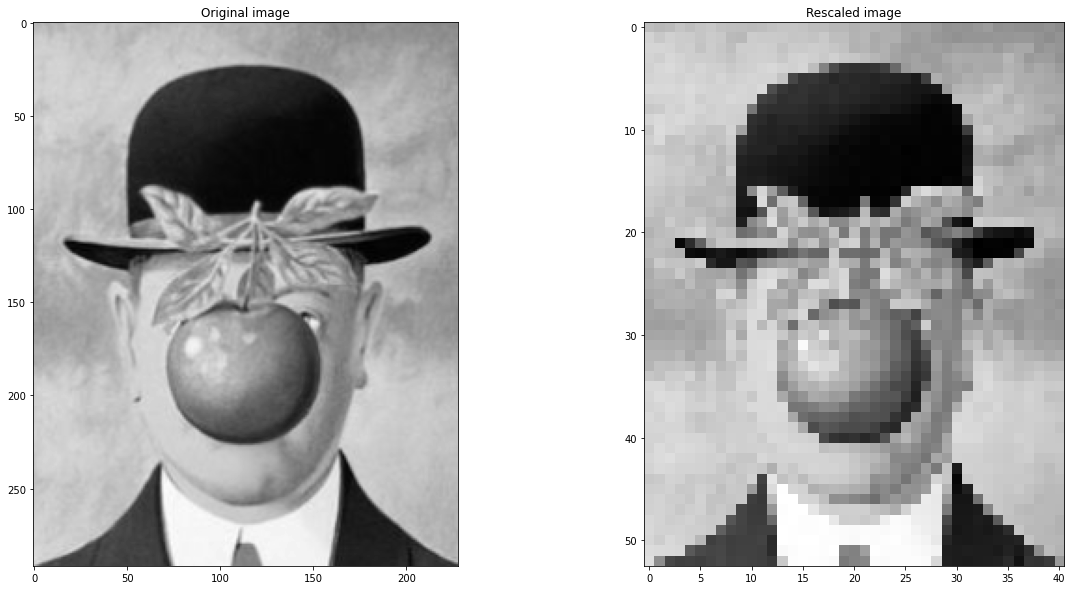

In [21]:
# import image and rescale 

img_path = 'drive/My Drive/AMATH482/HW5/SonOfMan.png'

# read image
img_og = ski.io.imread(img_path)

# convert to grayscale and visualize 
img_og = ski.color.rgb2gray(img_og)

fig, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].imshow(img_og, cmap = 'gray')
ax[0].set_title("Original image")

print("Original size: ", img_og.shape)

# resize image 
img = ski.transform.rescale( img_og, 0.18, anti_aliasing=False)

print("Rescaled size: ", img.shape)

ax[1].imshow(img, cmap='gray')
ax[1].set_title("Rescaled image")

In [22]:
# constrauct forward and inverse DCT matrices 

# construct DCT matrix
def construct_DCT_Mat( Nx, Ny ):

  # input : Nx number of columns of image 
  #         Ny number of rows of image 

  # output: D DCT matrix mapping image.flatten() to 
  #         DCT(image).flatten()

  Dx = spfft.dct(np.eye(Nx), axis =0, norm='ortho')

  Dy = spfft.dct(np.eye(Ny), axis = 0, norm='ortho')

  D = np.kron(Dy, Dx)

  return D

# construct inverse DCT matrix
def construct_iDCT_Mat( Nx, Ny ):

  # input : Nx number of columns of image 
  #         Ny number of rows of image 

  # output: iD iDCT matrix mapping DCT(image).flatten() to 
  #         image.flatten()

  Dx = spfft.idct(np.eye(Nx), axis =0, norm='ortho')

  Dy = spfft.idct(np.eye(Ny), axis = 0, norm = 'ortho')

  D = np.kron(Dy, Dx)

  return D

## Task 1: Image Compression

In [23]:
# Construct forward and inverse DCT matrices for the lower resolution image
DCT = construct_DCT_Mat(41, 53)
DCT_inv = construct_iDCT_Mat(41, 53)

(2173,)
(2173, 2173)


Text(0, 0.5, 'DCT(F)')

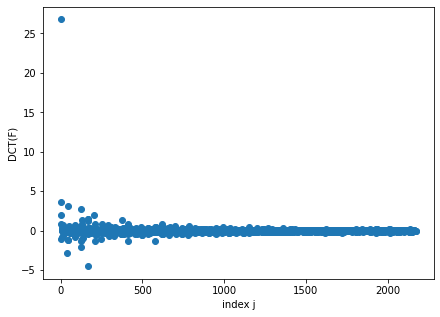

In [24]:
from IPython.core.pylabtools import figsize
# Flatten image
F = img.flatten()
print(F.shape)

# Plot DCT(F)
DCT_F = np.dot(DCT, F)
print(DCT.shape)
fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(range(2173), DCT_F)
ax.set_xlabel("index j")
ax.set_ylabel("DCT(F)")

In [25]:
# Function for thresholding DCT_F
def threshold(matrix, p):
  DCT_F_thresh = np.copy(matrix)

  # Threshold at percent 1 - p
  thresh = np.percentile(matrix, 100 - p)

  for i in range(len(matrix)):
    if np.abs(matrix[i]) < thresh:
      DCT_F_thresh[i] = 0

  # Compute vec(F) of DCT_F_Thresh using DCT_inv
  vec_F = np.dot(DCT_inv, DCT_F_thresh)

  # Reshape vec(F) to get image
  img_threshold = np.reshape(vec_F, (53,41))

  return img_threshold

In [ ]:
# Thresholding DCT_F to keep the top 5,10,20, and 40 percent of DCT coefficients and creating image
img_5 = threshold(DCT_F, 5)
img_10 = threshold(DCT_F, 10)
img_20 = threshold(DCT_F, 20)
img_40 = threshold(DCT_F, 40)

Text(0.5, 1.0, 'Top 40% of DCT Coefficients')

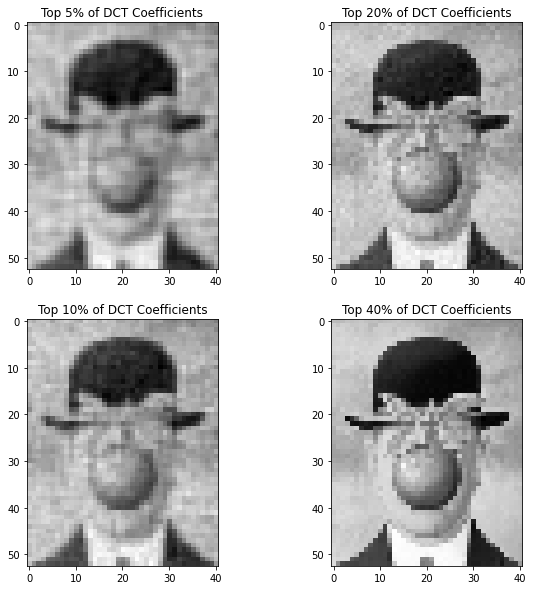

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))

ax[0,0].imshow(img_5, cmap = 'gray')
ax[0,0].set_title("Top 5% of DCT Coefficients")

ax[1,0].imshow(img_10, cmap = 'gray')
ax[1,0].set_title("Top 10% of DCT Coefficients")

ax[0,1].imshow(img_20, cmap = 'gray')
ax[0,1].set_title("Top 20% of DCT Coefficients")

ax[1,1].imshow(img_40, cmap = 'gray')
ax[1,1].set_title("Top 40% of DCT Coefficients")

## Task 2: Compressed Image Recovery

In [ ]:
# M = r * N for r = 0.2, 0.4, 0.6
N = 2173
M = round(.01 * N)

# Construct a measurement matrix B by randomly selecting M rows of the identity matrix I
B = np.random.permutation(np.eye(N))[:M]

# Generate vector of measurements y by applying B to vec(F)
y = np.dot(B, F)

# Define matrix A = BD^-1
A = np.dot(B, DCT_inv)


(22,)
(22, 2173)


In [26]:
# Function for obtaining x_star
def solve_x_star(r):
  N = 2173
  M = round(r * N)

  # Construct a measurement matrix B by randomly selecting M rows of the identity matrix I
  B = np.random.permutation(np.eye(N))[:M, :]

  # Generate vector of measurements y by applying B to vec(F)
  y = np.dot(B, F)

  # Define matrix A = BD^-1
  A = np.dot(B, DCT_inv)

  x = cvx.Variable(N)
  obj = cvx.Minimize(cvx.norm(x, 1))
  constraints = [(A @ x) == y]
  prob = cvx.Problem(obj, constraints)

  prob.solve(verbose=True, solver="CVXOPT", max_iter=1000, reltol=1e-2, featol=1e-2)
  x_star = x.value

  return x_star

In [ ]:
# Array for storing constructed images for different values of M
imgs = []

for r in [0.2, 0.4, 0.6]:
  for i in range(3):
    x_star = solve_x_star(r)
    F_star = np.dot(DCT_inv, x_star)
    img = np.reshape(F_star, (53,41))
    imgs.append(img)

np.save("drive/My Drive/AMATH482/HW5/imgs.npy", imgs)


Text(0.5, 1.0, 'r = 0.6')

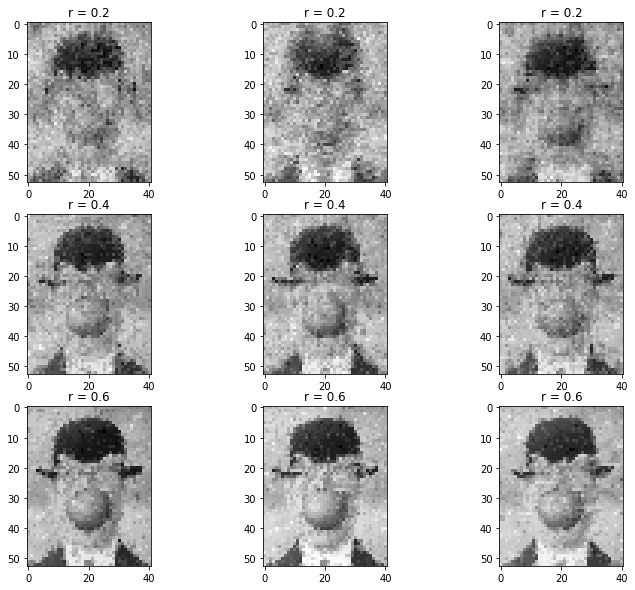

In [9]:

imgs = np.load("drive/My Drive/AMATH482/HW5/imgs.npy")

fig, ax = plt.subplots(3, 3, figsize=(12,10))

ax[0,0].imshow(imgs[0], cmap = 'gray')
ax[0,0].set_title("r = 0.2")
ax[0,1].imshow(imgs[1], cmap = 'gray')
ax[0,1].set_title("r = 0.2")
ax[0,2].imshow(imgs[2], cmap = 'gray')
ax[0,2].set_title("r = 0.2")

ax[1,0].imshow(imgs[3], cmap = 'gray')
ax[1,0].set_title("r = 0.4")
ax[1,1].imshow(imgs[4], cmap = 'gray')
ax[1,1].set_title("r = 0.4")
ax[1,2].imshow(imgs[5], cmap = 'gray')
ax[1,2].set_title("r = 0.4")

ax[2,0].imshow(imgs[6], cmap = 'gray')
ax[2,0].set_title("r = 0.6")
ax[2,1].imshow(imgs[7], cmap = 'gray')
ax[2,1].set_title("r = 0.6")
ax[2,2].imshow(imgs[8], cmap = 'gray')
ax[2,2].set_title("r = 0.6")

## Task 3: Mystery Image

In [ ]:
unknown_image = np.load("drive/My Drive/AMATH482/HW5/UnknownImage.npz", allow_pickle=True)
B = unknown_image["B"]
y = unknown_image["y"]

print(B.shape)
print(y.shape)

N = 2500
M = round(.6 * N)
DCT_inv = construct_iDCT_Mat(50, 50)

# Define matrix A = BD^-1
A = np.dot(B, DCT_inv)

x = cvx.Variable(N)
obj = cvx.Minimize(cvx.norm(x, 1))
constraints = [(A @ x) == y]
prob = cvx.Problem(obj, constraints)

prob.solve(verbose=True, solver="CVXOPT", max_iter=1000, reltol=1e-2, featol=1e-2)
x_star = x.value

F_star = np.dot(DCT_inv, x_star)
img = np.reshape(F_star, (50,50))



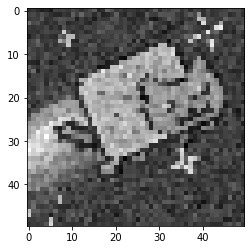

In [29]:
plt.imshow(img, 'gray')